In [2]:
import pandas as pd
import numpy as np

In [3]:
match_file = pd.read_csv('data_raw/match.csv')
match_file.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


In [4]:
# details of bit string is in :
# https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Player_Slot
def tower_status(ts_radiant, ts_dire):
    tsr = {}
    tsd = {}
    bit_tsr = '{0:016b}'.format(ts_radiant)
    bit_tsd = '{0:016b}'.format(ts_dire)
    tsr['top'] = bit_tsr.count('1', -3)
    tsd['top'] = bit_tsd.count('1', -3)
    tsr['mid'] = bit_tsr.count('1', 10, 13)
    tsd['mid'] = bit_tsd.count('1', 10, 13)
    tsd['bottom'] = bit_tsd.count('1', 7, 10)
    tsr['bottom'] = bit_tsr.count('1', 7, 10)
    tsd['ancient'] = bit_tsd.count('1', 5, 7)
    tsr['ancient'] = bit_tsr.count('1', 5, 7)
    return (tsr, tsd)

def barracks_status(bs_radiant, bs_dire):
    bsr = {}
    bsd = {}
    bit_bsr = '{0:08b}'.format(bs_radiant)
    bit_bsd = '{0:08b}'.format(bs_dire)
    bsr['top'] = bit_bsr.count('1', -2)
    bsd['top'] = bit_bsd.count('1', -2)
    bsr['mid'] = bit_bsr.count('1', 2, 4)
    bsd['mid'] = bit_bsd.count('1', 2, 4)
    bsd['bottom'] = bit_bsd.count('1', 4, 6)
    bsr['bottom'] = bit_bsr.count('1', 4, 6)
    return (bsr, bsd)

In [5]:
df_players = pd.read_csv(
    'data_raw/players.csv', 
    usecols=[
        'match_id',
        'player_slot',
        'gold',
        'gold_spent',
        'kills',
        'deaths',
        'assists',
        'denies',
        'last_hits',
        'hero_damage',
        'tower_damage',
        'level',
        'gold_buyback'
        ])
# df_player_time = pd.read_csv('dota-2-matches/player_time.csv')
# df_ability = pd.read_csv('dota-2-matches/ability_upgrades.csv')
df_team_fights = pd.read_csv('data_raw/teamfights.csv')
df_team_fights_players = pd.read_csv('data_raw/teamfights_players.csv')


## Novel feature: negative chat

We tried a custom known list of reliably negative words in chat as a novel feature. We count the number of occurrences of each word in the dictionary in chat per team per match.

In [6]:
df_chat = pd.read_csv('data_raw/chat.csv')
df_chat['key'].fillna('', inplace=True)

naughty_words = [
    'stfu',
    'ez',
    'fuck',
    'wtf',
    'blame',
    'report',
    'reported',
    'shit',
    'ass',
    'asshole',
    'idiot',
    'stupid',
    'support',
    'blyat',
    'noob',
    'gg'
]

def get_naughty_count(phrase):
    naughty_count = 0
    tokens = phrase.split()
    for token in tokens:
        naughty_count = naughty_count + (1 if token in naughty_words else 0)
    return naughty_count

df_chat['is_radiant'] = df_chat['slot'] < 5
df_chat['naughty_count'] = df_chat['key'].apply(get_naughty_count)
df_chat.head()

,match_id,key,slot,time,unit,is_radiant,naughty_count
0,0,force it,6,-8,6k Slayer,False,0
1,0,space created,1,5,Monkey,True,0
2,0,hah,1,6,Monkey,True,0
3,0,ez 500,6,9,6k Slayer,False,1
4,0,mvp ulti,4,934,Kira,True,0


In [48]:
df_chat['naughty_count'].describe()

count    1.439488e+06
mean     1.467015e-01
std      3.670513e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.000000e+00
Name: naughty_count, dtype: float64

We can see that the median negative word count is 0, and the majority of games have 0 instances of negative words. Thus, later we convert it to a binary feature (present or not).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001380ED6C7C0>]],
      dtype=object)

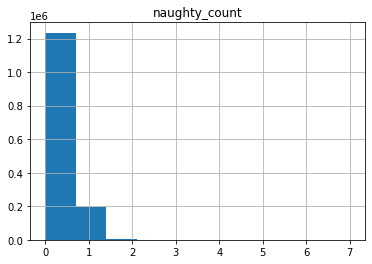

In [17]:
df_naughty_count_only = pd.DataFrame(df_chat['naughty_count'], columns=['naughty_count'])
df_naughty_count_only.hist()

In [50]:
df_match_grouped = df_chat.groupby(['match_id', 'is_radiant'], as_index=False).naughty_count.agg('sum')
df_match_grouped['radiant_naughty_count'] = np.where(df_match_grouped['is_radiant'] == True, df_match_grouped['naughty_count'], 0)
df_match_grouped['dire_naughty_count'] = np.where(df_match_grouped['is_radiant'] == False, df_match_grouped['naughty_count'], 0)
df_match_grouped.head()

,match_id,is_radiant,naughty_count,radiant_naughty_count,dire_naughty_count
0,0,False,2,0,2
1,0,True,3,3,0
2,1,False,1,0,1
3,1,True,0,0,0
4,2,False,2,0,2


In [52]:
df_match_naughty_counts = df_match_grouped.groupby(['match_id']).agg({
    'radiant_naughty_count': 'sum',
    'dire_naughty_count': 'sum'
})

df_match_naughty_counts.head()

,radiant_naughty_count,dire_naughty_count
match_id,,
0,3,2
1,0,1
2,1,2
3,1,2
4,1,3


In [54]:
match_data = []
match_file = match_file[match_file['game_mode'] == 22]
df_players.fillna(0, inplace=True)

radiant_pl = [0,1,2,3,4]
dire_pl = [128,129,130,131,132]
player_features = {
    'gold': 'full_total',
    'gold_spent': 'full_avg',
    'kills': 'only_total',
    'deaths': 'full_total',
    'assists': 'full_avg',
    'denies': 'full_avg',
    'last_hits': 'full_avg',
    'hero_damage': 'full_total',
    'tower_damage': 'full_total',
    'level': 'full_total',
    'gold_buyback': 'full_avg'
    }

In [56]:
df = df_players[(df_players.player_slot.isin(radiant_pl)) & (df_players.match_id == 0)]
df

,match_id,player_slot,gold,gold_spent,kills,deaths,assists,denies,last_hits,hero_damage,tower_damage,level,gold_buyback
0,0,0,3261,10960,9,3,18,1,30,8690,143,16,0.0
1,0,1,2954,17760,13,3,18,9,109,23747,423,22,0.0
2,0,2,110,12195,0,4,15,1,58,4217,399,17,-1015.0
3,0,3,1179,22505,8,4,19,6,271,14832,6055,21,0.0
4,0,4,3307,23825,20,3,17,13,245,33740,1833,24,-1056.0


In [58]:
tf = df_team_fights_players[df_team_fights_players.match_id == 0]
# for i in list(range(0,int(len(tf)/10))):
#     print(i*10,(i+1)*10)
a = tf[0:10]
d = sum(a[a.player_slot.isin(dire_pl)]['deaths'])
d

2

In [60]:
def teamfight_result(teamfights):
    loss_d = 0
    loss_r = 0
    for i in list(range(0,int(len(tf)/10))):
        tf_df = teamfights[i*10:(i+1)*10]
        rd = sum(tf_df[tf_df.player_slot.isin(radiant_pl)]['deaths'])
        dd = sum(tf_df[tf_df.player_slot.isin(dire_pl)]['deaths'])  
        if dd < rd:
            loss_r += 1
        elif rd < dd:
            loss_d += 1
    return (loss_r, loss_d)

In [62]:
def stat_agg(types: str, feature_name: str, data_list: str, team_data: dict):
    if types == "only_total":
        team_data[f'{feature_name}_total'] = sum(data_list)
    elif types == "full_total":
        team_data[f'{feature_name}_total'] = sum(data_list)
        team_data[f'{feature_name}_max'] = max(data_list)
        team_data[f'{feature_name}_min'] = min(data_list)
        team_data[f'{feature_name}_std'] = round(np.std(data_list), 4)
    elif types == "full_avg":
        team_data[f'{feature_name}_avg'] = np.average(data_list)
        team_data[f'{feature_name}_max'] = max(data_list)
        team_data[f'{feature_name}_min'] = min(data_list)
        team_data[f'{feature_name}_std'] = round(np.std(data_list), 4)

    return team_data

In [63]:
# filter_players = df_players.player_slot.isin(radiant_pl) & df_players['match_id'] == 0
df_players.dtypes

match_id          int64
player_slot       int64
gold              int64
gold_spent        int64
kills             int64
deaths            int64
assists           int64
denies            int64
last_hits         int64
hero_damage       int64
tower_damage      int64
level             int64
gold_buyback    float64
dtype: object

In [64]:
def aggregation_data(match_id, team, team_data: dict):
    # getting the player list
    player_ids = radiant_pl if team == 'radiant' else dire_pl

    filter_players = (df_players.player_slot.isin(player_ids)) & (df_players.match_id == match_id)
    df_team_players = df_players[filter_players]
    
    for feature in player_features:
        team_data = stat_agg(player_features[feature], feature, df_team_players[feature], team_data)

    return team_data

In [65]:
len(match_file)

48670

In [67]:
for idx, row in match_file.iterrows():
    match_id = row['match_id']
    duration = row['duration']

    # Tower, barracks, ancient status
    tower_radiant, tower_dire = tower_status(row['tower_status_radiant'], row['tower_status_dire'])
    barracks_radiant, barracks_dire = barracks_status(row['barracks_status_radiant'], row['barracks_status_dire'])

    # teamfights result
    loss_radiant, loss_dire = teamfight_result(df_team_fights_players[df_team_fights_players.match_id == match_id])

    # naughty word count
    naughty_counts = None
    try: 
        naughty_counts = df_match_naughty_counts.loc[match_id]
    except:
        pass

    radiant_naughty_count = 0
    dire_naughty_count = 0

    radiant_naughty_count = naughty_counts['radiant_naughty_count'] if naughty_counts is not None else 0
    dire_naughty_count = naughty_counts['radiant_naughty_count'] if naughty_counts is not None else 0

    #-- radiant --#
    # init
    team_radiant = {'match_id': match_id, 'duration': duration}
    # result
    team_radiant['result'] = 1 if row['radiant_win'] else 0
    # tower, barrack, ancient comparison data
    team_radiant['top_towers'] = tower_radiant['top'] - tower_dire['top']
    team_radiant['mid_towers'] = tower_radiant['mid'] - tower_dire['mid']
    team_radiant['bottom_towers'] = tower_radiant['bottom'] - tower_dire['bottom']
    team_radiant['ancient_status'] = tower_radiant['ancient'] - tower_dire['ancient']
    team_radiant['top_barracks'] = barracks_radiant['top'] - barracks_dire['top']
    team_radiant['mid_barracks'] = barracks_radiant['mid'] - barracks_dire['mid']
    team_radiant['bottom_barracks'] = barracks_radiant['bottom'] - barracks_dire['bottom']
    # aggregating data from players, abilities
    team_radiant = aggregation_data(match_id, 'radiant', team_radiant)
    # teamfight
    team_radiant['teamfight_loss'] = loss_radiant
    # naughty count
    team_radiant['has_negative_chat'] = True if radiant_naughty_count > 0 else False

    #-- dire --#
    # init
    team_dire = {'match_id': match_id, 'duration': duration}
    # result
    team_dire['result'] = 0 if row['radiant_win'] else 1
    # tower, barrack, ancient comparison data
    team_dire['top_towers'] = - tower_radiant['top'] + tower_dire['top']
    team_dire['mid_towers'] = - tower_radiant['mid'] + tower_dire['mid']
    team_dire['bottom_towers'] = - tower_radiant['bottom'] + tower_dire['bottom']
    team_dire['ancient_status'] = - tower_radiant['ancient'] + tower_dire['ancient']
    team_dire['top_barracks'] = - barracks_radiant['top'] + barracks_dire['top']
    team_dire['mid_barracks'] = - barracks_radiant['mid'] + barracks_dire['mid']
    team_dire['bottom_barracks'] = - barracks_radiant['bottom'] + barracks_dire['bottom']
    # aggregating data from players, abilities
    team_dire = aggregation_data(match_id, 'dire', team_dire)
    # teamfight
    team_dire['teamfight_loss'] = loss_dire
    # naughty word count
    team_dire['has_negative_chat'] = True if dire_naughty_count > 0 else False

    match_data.append(team_radiant)
    match_data.append(team_dire)

In [33]:
print('match data count: ', len(match_data))
match_data[0]

match data count:  6


{'match_id': 0,
 'duration': 2375,
 'result': 1,
 'top_towers': 1,
 'mid_towers': 3,
 'bottom_towers': 2,
 'ancient_status': 2,
 'top_barracks': 0,
 'mid_barracks': 2,
 'bottom_barracks': 2,
 'gold_total': 10811,
 'gold_max': 3307,
 'gold_min': 110,
 'gold_std': 1290.2002,
 'gold_spent_avg': 17449.0,
 'gold_spent_max': 23825,
 'gold_spent_min': 10960,
 'gold_spent_std': 5215.8388,
 'kills_total': 50,
 'deaths_total': 17,
 'deaths_max': 4,
 'deaths_min': 3,
 'deaths_std': 0.4899,
 'assists_avg': 17.4,
 'assists_max': 19,
 'assists_min': 15,
 'assists_std': 1.3565,
 'denies_avg': 6.0,
 'denies_max': 13,
 'denies_min': 1,
 'denies_std': 4.6476,
 'last_hits_avg': 142.6,
 'last_hits_max': 271,
 'last_hits_min': 30,
 'last_hits_std': 97.9155,
 'hero_damage_total': 85226,
 'hero_damage_max': 33740,
 'hero_damage_min': 4217,
 'hero_damage_std': 10610.3799,
 'tower_damage_total': 8853,
 'tower_damage_max': 6055,
 'tower_damage_min': 143,
 'tower_damage_std': 2222.8977,
 'level_total': 100,
 'le

In [68]:
df_match_data = pd.DataFrame(match_data)
df_match_data.to_csv('data_clean/cleaned_match_data')